In [56]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from tqdm.notebook import tqdm
tqdm.pandas()

import torch
import torchmetrics as tm
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [69]:
SESSION_DIR_PATH = Path("../../session")
DATA_DIR_PATH = Path("../../data")
SESSION_DIR_PATH = Path("../../session")
TRAIN_DATASET_PATH = DATA_DIR_PATH.joinpath("jigsaw2019-train.csv")
TEST_DATASET_PATH = DATA_DIR_PATH.joinpath("jigsaw2019-test.csv")
LABEL_LIST = ['toxicity', 'obscene', 'sexual_explicit',
            'identity_attack', 'insult', 'threat']
IDENTITY_LIST = ['male', 'female', 'transgender', 'other_gender', 'heterosexual',
                'homosexual_gay_or_lesbian', 'bisexual','other_sexual_orientation',
                'christian', 'jewish', 'muslim', 'hindu','buddhist', 'atheist',
                'other_religion', 'black', 'white', 'asian', 'latino',
                'other_race_or_ethnicity', 'physical_disability',
                'intellectual_or_learning_disability',
                'psychiatric_or_mental_illness','other_disability']
SELECTED_IDENTITY_LIST = ['male', 'female', 'black', 'white', 'homosexual_gay_or_lesbian',
                    'christian', 'jewish', 'muslim', 'psychiatric_or_mental_illness']

SELECTED_SESSION_INFO = [('glove-bilstm-bce_2022-03-31T18-54-19-824060', 'rnn', 141046211, 28),
                        ('roberta-fl_2022-03-30T11-53-46-595839', 'bert', 120657895, 20),
                        ('roberta-cbntrfl_2022-03-30T09-07-31-830794', 'bert', 211293320, 11),
                        ('roberta-pwbce_2022-03-30T15-57-44-127079', 'bert', 108850773, 13),
                        ('roberta-pwfl_2022-03-30T16-53-02-178977', 'bert', 33049403, 12),
                        ('unfreeze-glove-resnet44-bce_2022-03-31T07-05-17-083127', 'cnn', 286366972, 17),
                        ('roberta-dbfl_2022-03-30T10-03-00-862744', 'bert', 96241080, 13),
                        ('roberta-large-bce_2022-03-30T12-49-24-393100', 'bert', 97194374, 11)
                        ]

SELECTED_SESSION_NAME = [name for name, _,  _, _ in SELECTED_SESSION_INFO]
SELECTED_SESSION_PARAMS = [params for _, _, params, _ in SELECTED_SESSION_INFO]
SELECTED_SESSION_BATCHTIME = [batchtime for _, _, _, batchtime in SELECTED_SESSION_INFO]

In [58]:
validation_dataset_namespace = lambda session_name: f"{session_name}.jigsaw2019-validation.csv"
log_namespace = lambda session_name: f"{session_name}.loguru.log"
metric_namespace = lambda session_name: f"{session_name}.metric.json"
test_prediction_namespace = lambda session_name: f"{session_name}.test.csv"
validation_prediction_namespace = lambda session_name: f"{session_name}.validation.csv"

## Metrics en général

In [59]:
# Adapted from : https://gist.github.com/aditya-5842/b2a886f42bc9988dc11c1737a349830c

from sklearn.metrics import roc_auc_score

########################################################################################
#######################     function to calculate the AUC        #######################
########################################################################################

def cal_auc(y_true, y_pred):
    "returns the auc value"
    return roc_auc_score(y_true, y_pred)

########################################################################################
#######################  function to calculate the Subgroup AUC  #######################
########################################################################################

def cal_subgroup_auc(target_df, prediction_df, subgroups, label):
    subgroup_filter = target_df[subgroups] == 1
    return cal_auc(target_df[subgroup_filter][label], prediction_df[subgroup_filter][label])

########################################################################################
#######################   function to calculate the BPSN AUC     #######################
########################################################################################

def cal_bpsn_auc(target_df, prediction_df, subgroups, label):
    """This will calculate the BPSN auc"""
    subgroup_filter = target_df[subgroups] == 1
    positive_label_filter = target_df[label] == 1
    # subset where subgroup is True and target label is 0
    pred_subgroup_negative_examples = prediction_df[subgroup_filter & ~positive_label_filter]
    target_subgroup_negative_examples = target_df[subgroup_filter & ~positive_label_filter]

    # subset where subgroup is False and target label is 1
    pred_background_positive_examples = prediction_df[~subgroup_filter & positive_label_filter]
    target_background_positive_examples = target_df[~subgroup_filter & positive_label_filter]

    # combine above two sets
    pred_bpsn_examples = pd.concat([pred_subgroup_negative_examples, pred_background_positive_examples])
    target_bpsn_examples = pd.concat([target_subgroup_negative_examples, target_background_positive_examples])

    return cal_auc(target_bpsn_examples[label], pred_bpsn_examples[label])


########################################################################################
#######################   function to calculate the BNSP AUC     #######################
########################################################################################
def cal_bnsp_auc(target_df, prediction_df, subgroups, label):
    """This will calculate the BNSP auc"""
    subgroup_filter = target_df[subgroups] == 1
    positive_label_filter = target_df[label] == 1

    # subset where subgroup is True and target label is 1
    pred_subgroup_positive_examples = prediction_df[subgroup_filter & positive_label_filter]
    target_subgroup_positive_examples = target_df[subgroup_filter & positive_label_filter]

    # subset where subgroup is False and target label is 0
    pred_background_negative_examples = prediction_df[~subgroup_filter & ~positive_label_filter]
    target_background_negative_examples = target_df[~subgroup_filter & ~positive_label_filter]

    # combine above two sets
    pred_bnsp_examples = pd.concat([pred_subgroup_positive_examples, pred_background_negative_examples])
    target_bnsp_examples = pd.concat([target_subgroup_positive_examples, target_background_negative_examples])

    return cal_auc(target_bnsp_examples[label], pred_bnsp_examples[label])

########################################################################################
#######################    function to calculate Bias metric     #######################
########################################################################################
def cal_bias_metric(target_df, prediction_df, subgroups, label):
    """Computes per-subgroup metrics for all subgroups and one model
    and returns the dataframe which will have all three Bias metrices
    and number of exmaples for each subgroup"""
    records = []
    for subgroup in subgroups:
        record = {"subgroup": subgroup, "subgroup_size": len(target_df[target_df[subgroup] == 1])}
        record["subgroup_auc"] = cal_subgroup_auc(target_df, prediction_df, subgroup, label)
        record["bpsn_auc"]     = cal_bpsn_auc(target_df, prediction_df, subgroup, label)
        record["bnsp_auc"]     = cal_bnsp_auc(target_df, prediction_df, subgroup, label)

        records.append(record)
    submetric_df = pd.DataFrame(records)

    return submetric_df

########################################################################################
#######################   function to calculate Overall metric   #######################
########################################################################################
def cal_overall_auc(target_df, prediction_df, label):
    return roc_auc_score(target_df[label], prediction_df[label])

########################################################################################
#######################    function to calculate final metric    #######################
########################################################################################
def power_mean(series, p):
    total_sum = np.sum(np.power(series, p))
    return np.power(total_sum/len(series), 1/p)

def final_metric(submetric_df, overall_auc, p = -5, w = 0.25):
    generalized_subgroup_auc = power_mean(submetric_df["subgroup_auc"], p)
    generalized_bpsn_auc = power_mean(submetric_df["bpsn_auc"], p)
    generalized_bnsp_auc = power_mean(submetric_df["bnsp_auc"], p)
    
    overall_metric = w*overall_auc + w*(generalized_subgroup_auc
                                        + generalized_bpsn_auc
                                        + generalized_bnsp_auc)
    return overall_metric

def generalized_auc_metric(target_df, prediction_df, subgroups, label, p = -5):
    submetric_df = cal_bias_metric(target_df, prediction_df, subgroups, label)
    
    generalized_subgroup_auc = power_mean(submetric_df["subgroup_auc"], p)
    generalized_bpsn_auc = power_mean(submetric_df["bpsn_auc"], p)
    generalized_bnsp_auc = power_mean(submetric_df["bnsp_auc"], p)

    return dict(generalized_subgroup_auc=generalized_subgroup_auc, 
                generalized_bpsn_auc=generalized_bpsn_auc,
                generalized_bnsp_auc=generalized_bnsp_auc)

########################################################################################
#######################   function all above function into one   #######################
########################################################################################

def return_final_metric(target_df, prediction_df, subgroups, label):
    """Data is dataframe which include whole data 
    and it also has the predicted target column"""
    submetric_df = cal_bias_metric(target_df, prediction_df, subgroups, label)

    overall_auc =  cal_overall_auc(target_df, prediction_df, label)
    overall_metric = final_metric(submetric_df, overall_auc, p = -5, w = 0.25)

    return overall_metric, submetric_df

## Preparer les données

In [60]:
target_test_df = pd.read_csv(TEST_DATASET_PATH, index_col=0)
target_test_df = target_test_df[~target_test_df.white.isna()]# TO REMOVE
target_test_df[LABEL_LIST] = (target_test_df[LABEL_LIST] >= 0.5).astype(int)
target_test_df.reset_index(inplace=True)

In [61]:
identity_target_test_df = target_test_df[~target_test_df.white.isna()].copy()
identity_target_test_df[LABEL_LIST + IDENTITY_LIST] = (identity_target_test_df[LABEL_LIST + IDENTITY_LIST] >= 0.5).astype(int)
identity_target_test_df.reset_index(inplace=True)

## Fonction à appliquer pour chaque model

### Générique

In [62]:
def get_best_f1_threshold(session_name):
    # Path
    session_path = SESSION_DIR_PATH.joinpath(session_name)
    validation_target_path = session_path.joinpath(validation_dataset_namespace(session_name))
    validation_prediction_path = session_path.joinpath(validation_prediction_namespace(session_name))

    # Read files
    target_validation_df = pd.read_csv(validation_target_path, index_col=0)
    pred_validation_df = pd.read_csv(validation_prediction_path, index_col=0)

    # Clean data
    pred_validation_df = pred_validation_df[LABEL_LIST]
    target_validation_df = (target_validation_df[LABEL_LIST] >= 0.5).astype(int)

    # Create tensors
    target_tensor = torch.Tensor(target_validation_df.to_numpy()).to(int)
    prediction_tensor = torch.Tensor(pred_validation_df.to_numpy())

    thresholds = np.arange(0, 1, 0.001)
    scores = [tm.F1Score(threshold=t, average="micro")(prediction_tensor, target_tensor) for t in tqdm(thresholds, leave=False)]
    # get best threshold
    ix = np.argmax(scores)
    best_thresholds = thresholds[ix]
    return best_thresholds

### Groupe By

In [63]:
def perf_and_bias_metric_per_model(prediction_test_df : pd.DataFrame):
    result_metric_dict = dict()

    # Performance
    perf_metric_dict = dict()
    ## AUROC Macro
    perf_metric_dict["auroc_macro"] = tm.AUROC(num_classes=len(LABEL_LIST), average="macro")
    ## F1 Score Macro
    perf_metric_dict["f1_macro_50"] = tm.F1Score(num_classes=len(LABEL_LIST), average="macro", threshold=0.5)
    ## F1 Score Micro
    perf_metric_dict["f1_micro_50"] = tm.F1Score(num_classes=len(LABEL_LIST), average="micro", threshold=0.5)
    ## Micro F1@BestTh
    session_name = prediction_test_df["session_name"].to_list()[0]
    best_threshold = get_best_f1_threshold(session_name)
    perf_metric_dict["best_f1_micro"] = tm.F1Score(num_classes=len(LABEL_LIST), average="micro", threshold=best_threshold)
    
    ## Recall
    perf_metric_dict["recall_micro_50"] = tm.Recall(num_classes=len(LABEL_LIST), average="micro", threshold=0.5)
    ## Precision
    perf_metric_dict["precision_micro_50"] = tm.Precision(num_classes=len(LABEL_LIST), average="micro", threshold=0.5)

    perf_metric_collection = tm.MetricCollection(perf_metric_dict)

    pred_tensor = torch.Tensor(prediction_test_df[LABEL_LIST].to_numpy())
    target_tensor = torch.Tensor(target_test_df[LABEL_LIST].to_numpy()).to(int)
    perf_result_metric_dict = perf_metric_collection(pred_tensor, target_tensor)
    perf_result_metric_dict = {key:value.item() for key, value in perf_result_metric_dict.items()}
    result_metric_dict.update(perf_result_metric_dict)

    # Biais
    label = "toxicity"
    identity_prediction_test_df = pd.concat([prediction_test_df, identity_target_test_df[IDENTITY_LIST]], axis=1)
    result_metric_dict.update(generalized_auc_metric(identity_target_test_df, identity_prediction_test_df, SELECTED_IDENTITY_LIST, label))

    return pd.Series(result_metric_dict)

In [64]:
def identity_aur_per_sub_per_model(prediction_test_df):
    label = "toxicity"
    prediction_test_df = pd.concat([prediction_test_df, identity_target_test_df[IDENTITY_LIST]], axis=1)
    return cal_bias_metric(identity_target_test_df, prediction_test_df, SELECTED_IDENTITY_LIST, label)

In [65]:
def auroc_per_class_per_model(prediction_test_df):
    # TODO
    pass

## Calcul sur les sessions

In [66]:
prediction_test_df = None
for session_name in tqdm(SELECTED_SESSION_NAME):
    session_path = SESSION_DIR_PATH.joinpath(session_name)
    test_file_path =session_path.joinpath(test_prediction_namespace(session_name))
    current_test_df = pd.read_csv(test_file_path, index_col=0)
    current_test_df["session_name"] = session_name
    if prediction_test_df is None:
        prediction_test_df = current_test_df
    else:
        prediction_test_df = pd.concat([prediction_test_df, current_test_df])


  0%|          | 0/8 [00:00<?, ?it/s]

In [67]:
groupby_test_df = prediction_test_df.groupby("session_name")

### Perf & Biais Metric pour chaque Model

In [68]:
perf_and_bias_metric_per_model_df = groupby_test_df.progress_apply(perf_and_bias_metric_per_model)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
perf_and_bias_metric_per_model_df

#### Tableau des metriques en fonction des modèles

##### Renommer `session_name` et les colonnes

In [ ]:
perf_and_bias_metric_per_model_df.index = perf_and_bias_metric_per_model_df.index.map(lambda session_name: session_name.split("_")[0])
perf_and_bias_metric_per_model_df.index.name = "Model"

In [ ]:
rename_map = {
    "auroc_macro": "AUROC",
    "best_f1_micro": "F1@B",
    "f1_macro_50": "Macro F1",
    "f1_micro_50": "Micro F1",
    "precision_micro_50": "Precision",
    "recall_micro_50": "Recall",
    "generalized_subgroup_auc": "GMB Sub.",
    "generalized_bpsn_auc": "GMB BPSN",
    "generalized_bnsp_auc": "GMB BNSP",
}
perf_and_bias_metric_per_model_df.rename(rename_map, inplace=True)

In [ ]:
multi_columns = [('Performance', 'AUROC'),
                ('Performance', 'F1@B'),
                ('Performance', 'Macro F1'),
                ('Performance', 'Micro F1'),
                ('Performance', 'Precision'),
                ('Performance', 'Recall'),
                ('Bias', 'GMB Sub.'),
                ('Bias', 'GMB BPSN'),
                ('Bias', 'GMB BNSP')]

perf_and_bias_metric_per_model_df.columns = pd.MultiIndex.from_tuples(multi_columns)

In [ ]:
perf_and_bias_metric_per_model_df

##### Style

In [101]:
perf_and_bias_metric_per_model_style = perf_and_bias_metric_per_model_df.style.background_gradient(axis=0)
perf_and_bias_metric_per_model_style = perf_and_bias_metric_per_model_style.format(precision=4)
#perf_and_bias_metric_per_model_style = perf_and_bias_metric_per_model_style.applymap_index(lambda v: "rotatebox:{45}--rwrap--latex;", axis=1)

perf_and_bias_metric_per_model_style

In [102]:
perf_and_bias_metric_per_model_latex = perf_and_bias_metric_per_model_style.to_latex(
    convert_css=True,
    column_format="lllllll||lll",
    multicol_align="c||",
    hrules=True,
)
print(perf_and_bias_metric_per_model_latex)

\begin{tabular}{lllllll||lll}
\toprule
 & \multicolumn{6}{c||}{Performance} & \multicolumn{3}{c||}{Bias} \\
 & AUROC & F1@B & Macro F1 & Micro F1 & Precision & Recall & GMB Sub. & GMB BPSN & GMB BNSP \\
Model &  &  &  &  &  &  &  &  &  \\
\midrule
glove-bilstm-bce & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.9353 & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.5888 & {\cellcolor[HTML]{034A74}} \color[HTML]{F1F1F1} 0.2521 & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.5522 & {\cellcolor[HTML]{045687}} \color[HTML]{F1F1F1} 0.7234 & {\cellcolor[HTML]{60A1CA}} \color[HTML]{F1F1F1} 0.4465 & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.8590 & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.8496 & {\cellcolor[HTML]{023858}} \color[HTML]{F1F1F1} 0.9387 \\
roberta-cbntrfl & {\cellcolor[HTML]{1C7FB8}} \color[HTML]{F1F1F1} 0.9091 & {\cellcolor[HTML]{B9C6E0}} \color[HTML]{000000} 0.4389 & {\cellcolor[HTML]{056EAD}} \color[HTML]{F1F1F1} 0.2125 & {\cellcolor[HTML]{0A73B2}} \co

Il faut encadrer ce code par :
```latex
\usepackage{booktabs}
\usepackage[table]{xcolor}
\usepackage{graphicx}

\begin{table*}[htb!]
\resizebox{1.0\linewidth}{!}{
%%%

% Write HERE

%%%
}
\caption{Model performance results}
\label{tab:results}
\end{table*}
```

#### Performance en fonction du temps par batch et de la taille du modèle

In [94]:
perf_and_info_per_model_df = perf_and_bias_metric_per_model_df.copy()

params_dict = {session_name:params for session_name, _, params, _ in SELECTED_SESSION_INFO}
batchtime_dict = {session_name:batchtime for session_name, _, _, batchtime in SELECTED_SESSION_INFO}
model_type_dict = {session_name:model_type for session_name, model_type, _, _ in SELECTED_SESSION_INFO}

perf_and_info_per_model_df["parameters"] = perf_and_info_per_model_df.apply(lambda row: params_dict[row.name], axis=1)
perf_and_info_per_model_df["batch_time"] = perf_and_info_per_model_df.apply(lambda row: batchtime_dict[row.name], axis=1)
perf_and_info_per_model_df["model_type"] = perf_and_info_per_model_df.apply(lambda row: model_type_dict[row.name], axis=1)

perf_and_info_per_model_df.index = perf_and_info_per_model_df.index.map(lambda session_name: session_name.split("_")[0])

In [95]:
perf_and_info_per_model_df.head(2)

,auroc_macro,best_f1_micro,f1_macro_50,f1_micro_50,precision_micro_50,recall_micro_50,generalized_subgroup_auc,generalized_bpsn_auc,generalized_bnsp_auc,parameters,batch_time,model_type
session_name,,,,,,,,,,,,
glove-bilstm-bce,0.935262,0.588833,0.25206,0.552191,0.723408,0.446510,0.858984,0.849617,0.938739,141046211,28,rnn
roberta-cbntrfl,0.909091,0.438919,0.21246,0.425160,0.463837,0.392436,0.793659,0.738241,0.888559,211293320,11,bert


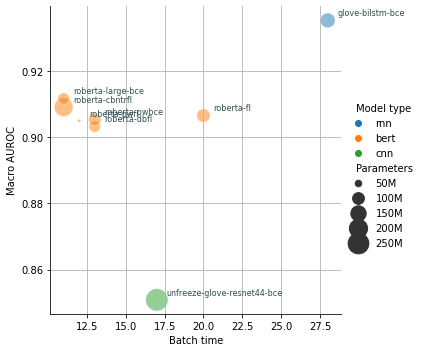

In [114]:
rename_label_dict = {
    "model_type":"Model type",
    "parameters":"Parameters",
    "0.5":"50M",
    "1.0":"100M",
    "1.5":"150M",
    "2.0":"200M",
    "2.5":"250M",
}

g = sns.relplot(
    data=perf_and_info_per_model_df,
    x="batch_time", y="auroc_macro",
    size="parameters",
    hue="model_type", sizes=(10, 500),
    alpha=0.5,
)

for t in g._legend.texts:
    t.set_text(rename_label_dict.get(t.get_text(), t.get_text()))
#g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True)
g.ax.yaxis.grid(True)
plt.xlabel("Batch time")
plt.ylabel("Macro AUROC")

#for i in range(perf_and_info_per_model_df.shape[0]):
#    g.ax.text(perf_and_info_per_model_df.batch_time[i] + 2, perf_and_info_per_model_df.auroc_macro[i] + 0.005, perf_and_info_per_model_df.index[i], horizontalalignment='center', size='medium', color='black', weight='semibold')

for k, v in perf_and_info_per_model_df.iterrows():
    g.ax.annotate(k, (v.batch_time, v.auroc_macro),
                xytext=(10,5), textcoords='offset points',
                family='sans-serif', fontsize=8, color='darkslategrey')

plt.savefig('perf_and_info_per_model_df.svg')
plt.show()

### Histograme AUC par modèle et par identité

In [13]:
identity_aur_per_sub_per_model_df = groupby_test_df.progress_apply(identity_aur_per_sub_per_model)
identity_aur_per_sub_per_model_df.reset_index(inplace=True)
identity_aur_per_sub_per_model_df = identity_aur_per_sub_per_model_df.melt(id_vars=["session_name", "subgroup"], value_vars=["subgroup_auc", "bpsn_auc", "bnsp_auc"])

  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
identity_aur_per_sub_per_model_df

,session_name,subgroup,variable,value
0,glove-bilstm-bce,male,subgroup_auc,0.904540
1,glove-bilstm-bce,female,subgroup_auc,0.910807
2,glove-bilstm-bce,black,subgroup_auc,0.811313
3,glove-bilstm-bce,white,subgroup_auc,0.827163
4,glove-bilstm-bce,homosexual_gay_or_lesbian,subgroup_auc,0.811624
...,...,...,...,...
211,unfreeze-glove-resnet44-bce,homosexual_gay_or_lesbian,bnsp_auc,0.895608
212,unfreeze-glove-resnet44-bce,christian,bnsp_auc,0.850146
213,unfreeze-glove-resnet44-bce,jewish,bnsp_auc,0.880808
214,unfreeze-glove-resnet44-bce,muslim,bnsp_auc,0.904757


In [19]:
# Rename session_name / subgroup
identity_aur_per_sub_per_model_df["session_name"] = identity_aur_per_sub_per_model_df["session_name"].apply(lambda session_name: session_name.split("_")[0])

renam_subgroup_dict = {
    "homosexual_gay_or_lesbian":"homosexual",
    "psychiatric_or_mental_illness":"psychiatric"
}
identity_aur_per_sub_per_model_df["subgroup"] = identity_aur_per_sub_per_model_df["subgroup"].apply(lambda subgroup: renam_subgroup_dict.get(subgroup, subgroup))

In [32]:
import plotly.express as px

labels={
    "subgroup_auc": "Sub. AUC",
    "bpsn_auc": "BPSN AUC",
    "bnsp_auc": "BNSP AUC",
    "subgroup":"",
    "session_name": "Model",
    "value":"AUC"
}

fig = px.bar(identity_aur_per_sub_per_model_df, x="subgroup", y="value", 
            color="session_name", barmode="group",
            facet_col="variable", labels=labels, range_y=[0.5, 1.0], width=1500)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.for_each_annotation(lambda a: a.update(text=labels.get(a.text, a.text)))

fig.write_image("identity_aur_per_sub_per_model_df.svg")
fig.show()



* La tableau des AUROC par classe (toxicity, obscene, ...) en fonction du modèle
* Le graph qui place les modèles de AUROC en fonction du nombre de paramètres, avec des points qui ont différentes couleurs en fonction de la famille du modèle (type BERT, type CNN, ...)